# Intro

This notebook presents how to use LLama Index library in connection with any selected LLM to build knowledge graph from plain text.

In an additional Python module I provide convenience functions to setup the LLM for LLama index. When preparing this material I was using local instance of LLama, so when replicating results or playing with it, remember to adjust the code for your needs.

# Lib imports

In [25]:
import os
import llm_utils as utils
import networkx as nx
import pyvis as pv
import matplotlib.pyplot as plt

from IPython.display import HTML

from llama_index import (
    ServiceContext,
    SimpleDirectoryReader,
    KnowledgeGraphIndex,
    set_global_service_context,
    PromptTemplate
)
from llama_index.prompts.default_prompts import DEFAULT_KG_TRIPLET_EXTRACT_TMPL

# LLM setup

Now let's set up the LLM model. For the sake of this tutorial - I rely on local instance of LLama2. You can experiment and play with any model of your choice - either from OpenAI, AzureOpenAI or any other. 

Utils lib provides some convenience functions to setup the LLM for LLama index.

In [2]:
llm, embed = utils.setup_local_llama()

We can check if our LLM repsonds to queries?

In [3]:
resp = llm.complete("Albert Einstein was")
print(resp)

a German-born theoretical physicist who is best known for his theory of relativity, specifically the mass-energy equivalence formula E=mc². He was born on March 14, 1879, in Ulm, Germany, and died on April 18, 1955, in Princeton, New Jersey, USA. Einstein's work has had a significant impact on the development of modern physics, and he is widely regarded as one of the most influential scientists of the 20th century. In 1921, he was awarded the Nobel Prize in Physics for his discovery of the photoelectric effect, which contributed to the development of quantum theory.


# Setting up a Llama index

## **First step** - service context steup

It is responsible for handling LLM and embedding model interactions.

In [4]:
service_context = ServiceContext.from_defaults(llm=llm, embed_model=embed)
set_global_service_context(service_context)

## **Second step** - reading documents

Now we will read from directory into the Llama index.

In [5]:
documents = SimpleDirectoryReader(os.path.join(os.pardir, 'data')).load_data()

In [8]:
documents[0].text[:50]

'It is no secret that the two most recent U.S. Pres'

## **Third step** - building index

Now we will build Knowledge Graph Index. Under the hood LLM, after reading the text will respond with triplets (subject, predicate, object). We will use them to build the index.

We will change the extraction prompt, so the LLM will try to use the same name for different entities.
For this purpose we will modify the existing, default prompt template.

In [17]:
prompt_text = DEFAULT_KG_TRIPLET_EXTRACT_TMPL[:-23] + """
When you encounter entities that look similar but are differently spelled (e.g. John Doe and J. Doe),
use one name for all occurences, when extracting them from text.

Text: {text}

Triplets:
"""

print(prompt_text)

Some text is provided below. Given the text, extract up to {max_knowledge_triplets} knowledge triplets in the form of (subject, predicate, object). Avoid stopwords.
---------------------
Example:Text: Alice is Bob's mother.Triplets:
(Alice, is mother of, Bob)
Text: Philz is a coffee shop founded in Berkeley in 1982.
Triplets:
(Philz, is, coffee shop)
(Philz, founded in, Berkeley)
(Philz, founded in, 1982)
---------------------

When you encounter entities that look similar but are differently spelled (e.g. John Doe and J. Doe),
use one name for all occurences, when extracting them from text.

Text: {text}

Triplets:



In [18]:
prompt_template = PromptTemplate(prompt_text)

In [19]:
kgi = KnowledgeGraphIndex.from_documents(
    documents, 
    max_triplets_per_chunk=50,
    prompt_template=prompt_template)

(US Presidents, have had, different approaches)
(Donald Trump, taking, conservative stance)
(Donald Trump, taking, divisive stance)
(Joe Biden, emphasizing, importance of international cooperation)
(Joe Biden, restoring, normalcy to White House)
(Joe Biden, has, more traditional policies)
(Joe Biden, has, centrist policies)
(Trump, known for, America First approach)
(Trump, pulling back from, international agreements)
(Trump, prioritizing, interests of United States)
(Trump, had, tumultuous relationship with world leaders)
(Biden, emphasized, international cooperation)
(Biden, rebuilding, relationships with allies)
(Biden, rejoined, Paris Climate Agreement)
(Biden, rejoined, World Health Organization)
(Biden, repairing, relationships with Mexico and Canada)
(Biden, taking, diplomatic approach with Iran and North Korea)
(Trump, pursued, conservative agenda)
(Trump, attempted to repeal, Affordable Care Act)
(Trump, rolled back, environmental regulations)
(Trump, cut taxes, for businesses

# Knowledge graph inspection
Now we can inspect the underlying knowledge graph constructed by the LLM.a

In [20]:
graph = kgi.graph_store
graph.get("Biden")

[['emphasized', 'international cooperation'],
 ['rebuilding', 'relationships with allies'],
 ['rejoined', 'Paris Climate Agreement'],
 ['rejoined', 'World Health Organization'],
 ['repairing', 'relationships with Mexico and Canada'],
 ['taking', 'diplomatic approach with Iran and North Korea'],
 ['pursued', 'liberal agenda'],
 ['focusing on', 'racial justice'],
 ['focusing on', 'healthcare'],
 ['focusing on', 'climate change'],
 ['signed', 'executive orders on voting rights'],
 ['signed', 'executive orders on gun control'],
 ['signed', 'executive orders on climate change'],
 ['proposed', 'legislation on healthcare'],
 ['proposed', 'legislation on infrastructure'],
 ['proposed', 'legislation on immigration reform'],
 ['emphasized', 'working with Congress'],
 ['emphasized', 'building consensus'],
 ['taken', 'conciliatory approach'],
 ['emphasized', 'bringing people together'],
 ['emphasized', 'finding common ground'],
 ['restored', 'normalcy to White House'],
 ['restored', 'professionali

In [21]:
graph.get("Trump")

[['known for', 'America First approach'],
 ['pulling back from', 'international agreements'],
 ['prioritizing', 'interests of United States'],
 ['had', 'tumultuous relationship with world leaders'],
 ['pursued', 'conservative agenda'],
 ['attempted to repeal', 'Affordable Care Act'],
 ['rolled back', 'environmental regulations'],
 ['cut taxes', 'for businesses and wealthy'],
 ['implemented', 'hardline immigration policies'],
 ['implemented', 'zero tolerance policy at border'],
 ['implemented', 'travel ban targeting Muslim countries'],
 ['known for', 'bold approach'],
 ['known for', 'combative approach'],
 ['used', 'Twitter to attack opponents'],
 ['faced', 'accusations of corruption'],
 ['faced', 'accusations of abuse of power'],
 ['faced', 'impeachment trial']]

Number of connected components: 4


Text(0.5, 1.0, 'Distribution of node degrees')

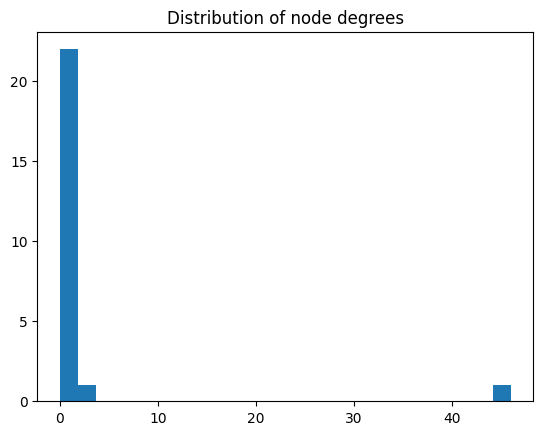

In [24]:
# Get the number of connected components
print(f"Number of connected components: {nx.number_connected_components(nx_graph)}")

# Get the distribution of node degrees
plt.hist(nx.degree_histogram(nx_graph), bins=25);
plt.title("Distribution of node degrees")


In [26]:
net = pv.network.Network('1000px', '1000px', 
                         notebook=True, 
                         select_menu=True,
                        filter_menu=True)
net.from_nx(kgi.get_networkx_graph())
net.show("LLM_graph.html")

HTML(filename="LLM_graph.html")

LLM_graph.html


# Knowledge graph querying

We can also qeury the knowledge graph to extract some information. 


## Getting reponses based on raw triplets

We can query the knowledge base to get responses based **ONLY** on the raw triplets. LLM will compose them together to produce the answer.

In [27]:
kgi_graph_query_engine = kgi.as_query_engine(include_text=False, response_mode="tree_summarize")
graph_resp1 = kgi_graph_query_engine.query("Summarize information about Trump")

In [28]:
print(graph_resp1)

Trump is known for his America First approach, prioritizing the interests of the United States and pulling back from international agreements. He had a tumultuous relationship with world leaders and pursued a conservative agenda. Some of his actions included attempting to repeal the Affordable Care Act, rolling back environmental regulations, cutting taxes for businesses and the wealthy, and implementing hardline immigration policies such as the zero tolerance policy at the border and a travel ban targeting Muslim countries. Trump is also known for his bold and combative approach, using Twitter to attack opponents. He faced accusations of corruption, abuse of power, and underwent an impeachment trial.


## Getting responses as rich text

When we want to have more naturally-structured responses, Lama-index will do the following:

1. Insert the query into the prompt
2. Find proper Knowledge Graph elements matching the query - adds them to prompt as well.
3. Run the LLM to get the response in a nice format.

In [66]:
kg_query_engine = kgi.as_query_engine()

In [72]:
kg_resp1 = kg_query_engine.query("Compare agendas pursued by both Trump and Biden. Start explanation for each candidate from newline (\n)")
print(kg_resp1)

Trump pursued a largely conservative agenda, focusing on efforts to repeal the Affordable Care Act, rolling back environmental regulations, cutting taxes for businesses and the wealthy, and implementing hardline immigration policies such as the zero tolerance policy at the border and the travel ban targeting predominantly Muslim countries.

Biden, on the other hand, has pursued a more liberal agenda, with a focus on addressing issues such as racial justice, healthcare, and climate change. He has signed executive orders on voting rights, gun control, and climate change issues and proposed legislation on healthcare, infrastructure, and immigration reform.


In [73]:
kg_resp2 = kg_query_engine.query("Compare general approaches of Trump and Biden to various topics. Briefly summarize each approach. Start explanation for each candidate from newline (\n)")
print(kg_resp2)

Trump:
- "America First" approach in foreign policy, prioritizing U.S. interests and pulling back from international agreements
- Tumultuous relationships with world leaders
- Pursued a conservative domestic agenda, including attempts to repeal the Affordable Care Act, rolling back environmental regulations, and cutting taxes for businesses and the wealthy
- Implemented hardline immigration policies, such as the zero tolerance policy and travel ban
- Bold and combative leadership style, often using Twitter to attack opponents and make controversial statements

Biden:
- Emphasizes international cooperation and rebuilding relationships with allies in foreign policy
- Rejoined the Paris Climate Agreement and the World Health Organization, and worked to repair relationships with countries like Mexico and Canada
- Pursues a liberal domestic agenda, focusing on racial justice, healthcare, and climate change
- Signed executive orders on voting rights, gun control, and climate change, and prop